# Neural Networks

In [3]:
from pathlib import Path
import pandas as pd
import numpy as np
import pandas_profiling
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
from sklearn.preprocessing import MinMaxScaler

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import model_from_json

Using TensorFlow backend.


In [6]:
import joblib

In [10]:
### Loading up Variables:
def get_data_splitted(pollutant, city):
    train_X = joblib.load("data/train/{}/X/{}.joblib".format(pollutant, city))
    train_y = joblib.load("data/train/{}/y/{}.joblib".format(pollutant, city))
    valid_X = joblib.load("data/valid/{}/X/{}.joblib".format(pollutant, city))
    valid_y = joblib.load("data/valid/{}/y/{}.joblib".format(pollutant, city))
    test_X = joblib.load("data/test/{}/X/{}.joblib".format(pollutant, city))
    test_y = joblib.load("data/test/{}/y/{}.joblib".format(pollutant, city))

    return (train_X, train_y, valid_X, valid_y, test_X, test_y)


def get_unsplit_data(city):
    return joblib.load("data/full_splits/{}.joblib".format( city))

def idx2CityName(idx):
    mapping = {0 : 'Aotizhongxin', 
     1 : 'Changping',
     2 : 'Dingling',
     3 : 'Dongsi',
     4 : 'Guanyuan',
     5 : 'Gucheng',
     6 : 'Huairou',
     7 : 'Nongzhanguan',
     8 : 'Shunyi',
     9 : 'Tiantan',
     10 : 'Wanliu',
     11 : 'Wanshouxigong'}
    
    return mapping[idx]

def cityName2Idx(cityName):
    mapping = {'Aotizhongxin' : 0, 
     'Changping' : 1,
     'Dingling' : 2,
     'Dongsi' : 3,
     'Guanyuan' : 4,
     'Gucheng' : 5,
     'Huairou' : 6,
     'Nongzhanguan' : 7,
     'Shunyi' : 8,
     'Tiantan' : 9,
     'Wanliu' : 10,
     'Wanshouxigong' : 11}
    
    return mapping[cityName]

def split(df, resp_col):
    cols = df.columns
    pred_cols = [pred_col for pred_col in cols if pred_col is not resp_col]
    X = df[pred_cols]
    y = df[resp_col]
    
    
    return X, y

def perform_grid_search_cross_validation(model, X_train, y_train, grid_param, scoring='accuracy', cv=5, n_jobs=1):
    gd_sr = GridSearchCV(estimator=model, param_grid=grid_param, scoring=scoring, cv=cv, n_jobs=n_jobs)
    gd_sr.fit(X_train, y_train)
    return gd_sr.best_params_
    

def validate_prediction(y, y_pred):
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)

    return "mse = {mse} & mae = {mae} & rmse = {rmse}".format(mse=mse, mae=mae, rmse=sqrt(mse))

## Univariate Recurrence Models

In [11]:
dfs = []
for idx in range(0,12):
    df = get_unsplit_data(idx2CityName(idx))
    dfs.append(df)

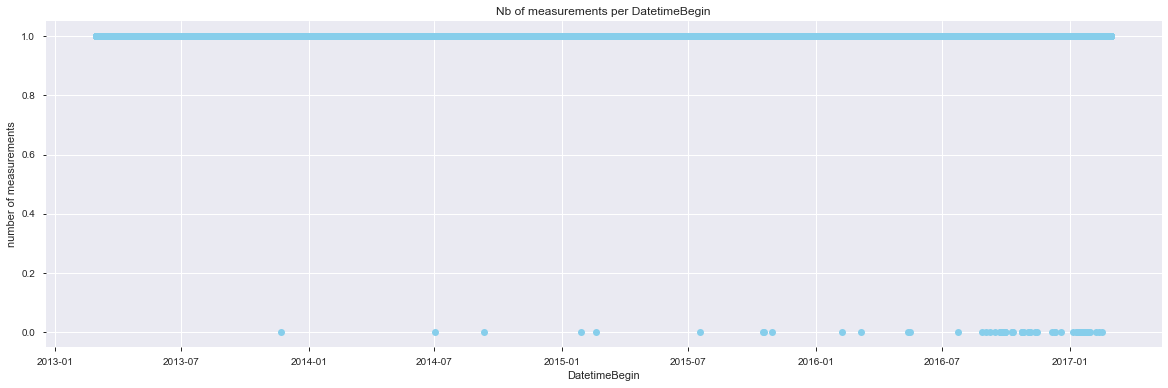

In [12]:
plt.figure(figsize=(20,6))
plt.plot(dfs[0].groupby('timestamp').count(), 'o', color='skyblue')
plt.title('Nb of measurements per DatetimeBegin')
plt.ylabel('number of measurements')
plt.xlabel('DatetimeBegin')
plt.show()

In [92]:
df = dfs[0]
df = pd.get_dummies(df, columns=['wd'])
df.drop(['station', 'wd_WSW'], axis=1, inplace=True)

In [93]:
train = df.query('timestamp < "2015-07-01"')
valid = df.query('timestamp >= "2015-07-01" and timestamp < "2016-05-01"')
test = df.query('timestamp >= "2016-05-01"')

cols = train.columns
train_idx = train.index
valid_idx = valid.index
test_idx = test.index

train = pd.DataFrame(train, columns=cols, index=train_idx).values.astype('float32')
valid = pd.DataFrame(valid, columns=cols, index=valid_idx).values.astype('float32')
test = pd.DataFrame(test, columns=cols, index=test_idx).values.astype('float32')

TypeError: float() argument must be a string or a number, not 'Timestamp'

In [80]:
def plot_loss(history, title):
    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(title)
    plt.xlabel('Nb Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    val_loss = history.history['val_loss']
    min_idx = np.argmin(val_loss)
    min_val_loss = val_loss[min_idx]
    print('Minimum validation loss of {} reached at epoch {}'.format(min_val_loss, min_idx))

In [88]:
n_lag = 25
train_data_gen = TimeseriesGenerator(train, train, length=n_lag, sampling_rate=1, stride=1, batch_size = 5)
valid_data_gen = TimeseriesGenerator(train, train, length=n_lag, sampling_rate=1, stride=1, batch_size = 1)
test_data_gen = TimeseriesGenerator(test, test, length=n_lag, sampling_rate=1, stride=1, batch_size = 1)

In [90]:
simple_rnn = Sequential()
simple_rnn.add(SimpleRNN(4, input_shape=(n_lag, 1)))
simple_rnn.add(Dense(1))
simple_rnn.compile(loss='mae', optimizer=RMSprop())

checkpointer = ModelCheckpoint(filepath='data/model/simple_rnn_weights.hdf5'
                               , verbose=0
                               , save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss'
                             , patience=10
                             , verbose=0)
with open("data/model/simple_rnn.json", "w") as m:
    m.write(simple_rnn.to_json())

simple_rnn_history = simple_rnn.fit_generator(train_data_gen
                                              , epochs=100
                                              , validation_data=valid_data_gen
                                              , verbose=0
                                              , callbacks=[checkpointer, earlystopper])
plot_loss(simple_rnn_history, 'SimpleRNN - Train & Validation Loss')

ValueError: Error when checking input: expected simple_rnn_14_input to have shape (25, 1) but got array with shape (25, 25)

In [58]:
len(valid_data_gen)

20436

In [68]:
valid[5452]

KeyError: 5452